Using device: cuda
Observation Space: Box(0, 255, (4, 84, 84), uint8)
Type: <class 'gymnasium.spaces.box.Box'>
Episode 1 - Total Reward: -20.0 - Epsilon: 0.999 - Loss: 0.015
Episode 2 - Total Reward: -19.0 - Epsilon: 0.999 - Loss: 0.016
Episode 3 - Total Reward: -20.0 - Epsilon: 0.998 - Loss: 0.001
Episode 4 - Total Reward: -21.0 - Epsilon: 0.998 - Loss: 0.045
Episode 5 - Total Reward: -21.0 - Epsilon: 0.997 - Loss: 0.015
Episode 6 - Total Reward: -20.0 - Epsilon: 0.996 - Loss: 0.015
Episode 7 - Total Reward: -21.0 - Epsilon: 0.996 - Loss: 0.030
Episode 8 - Total Reward: -21.0 - Epsilon: 0.995 - Loss: 0.000
Episode 9 - Total Reward: -19.0 - Epsilon: 0.994 - Loss: 0.030
Episode 10 - Total Reward: -21.0 - Epsilon: 0.994 - Loss: 0.045
Episode 11 - Total Reward: -19.0 - Epsilon: 0.993 - Loss: 0.043
Episode 12 - Total Reward: -19.0 - Epsilon: 0.993 - Loss: 0.014
Episode 13 - Total Reward: -21.0 - Epsilon: 0.992 - Loss: 0.001
Episode 14 - Total Reward: -21.0 - Epsilon: 0.991 - Loss: 0.031
Ep

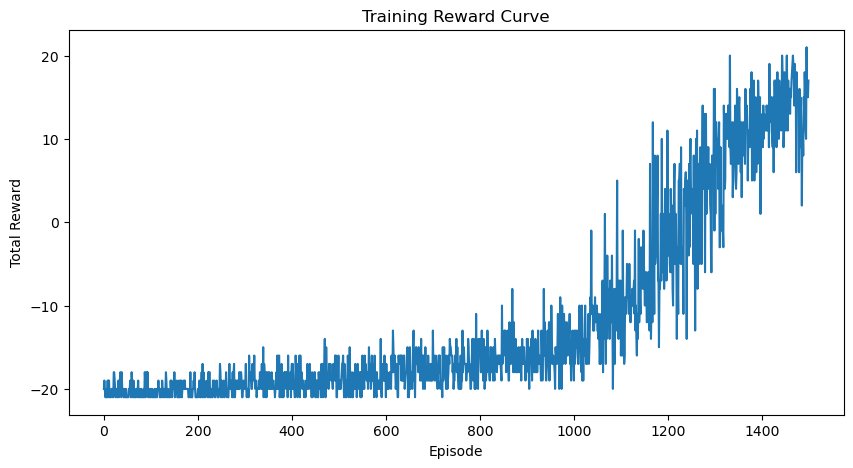

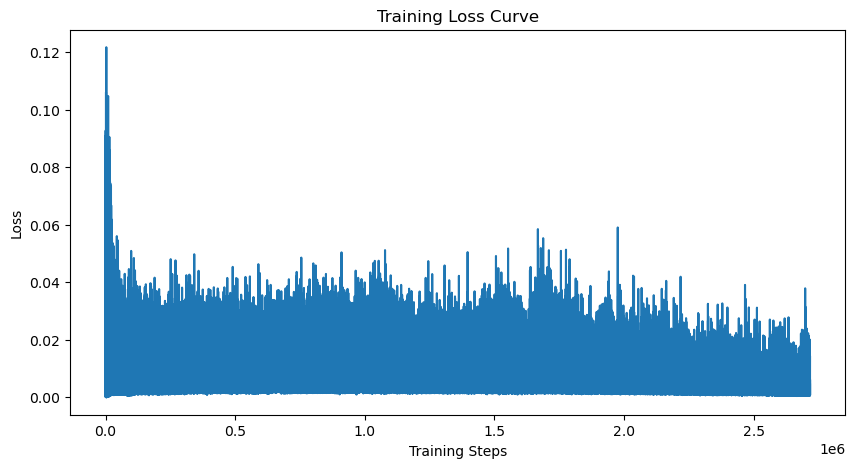

In [16]:
# Group Memebers:
# Neo Nkosi: 2437872
# Joshua Moorhead: 2489197
# Naomi Muzamani: 2456718
#PraiseGod Emenike: 2428608

import torch
import torch.backends.cudnn as cudnn  # Added import
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

from dqn.agent import DQNAgent
from dqn.replay_buffer import ReplayBuffer
from dqn.wrappers import make_atari, wrap_deepmind

cudnn.benchmark = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

env_name = 'PongNoFrameskip-v4'

env = make_atari(env_name)
env = wrap_deepmind(env, frame_stack=True, scale=False)  # Set scale=False since we're normalizing in the agent

print("Observation Space:", env.observation_space)
print("Type:", type(env.observation_space))

replay_buffer = ReplayBuffer(size=100000)

batch_size = 64

agent = DQNAgent(
    observation_space=env.observation_space,
    action_space=env.action_space,
    replay_buffer=replay_buffer,
    use_double_dqn=True,
    lr=1e-5,
    batch_size=batch_size,
    gamma=0.99
)

# Training parameters
num_episodes = 1500
target_update_interval = 5  # Update target network every 10 episodes
epsilon = 1.0
# epsilon = 0.005 -> linear till ep 180 then epsilon =0.1
# epsilon = 0.0025 -> linear till ep 360 then epsilon =0.1
# epsilon = 0.00125 -> linear till ep 720 then epsilon =0.1
# epsilon = 0.000625 -> linear till ep 1440 then epsilon =0.1


epsilon_decay = 0.000625
epsilon_min = 0.1
rewards = []
losses = []

for episode in range(1, num_episodes + 1):
    state, _ = env.reset()
    total_reward = 0
    t = 0

    while True:
        t += 1

        # Epsilon-greedy action selection
        if np.random.rand() < epsilon:
            action = env.action_space.sample()
        else:
            action = agent.act(state)

        # Take a step in the environment
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        # Add experience to replay buffer
        agent.replay_buffer.add(state, action, reward, next_state, float(done))

        state = next_state
        total_reward += reward

        # Optimize the model
        loss = agent.optimise_td_loss()
        if loss is not None:
            losses.append(loss)

        if done:
            break

    # Decay epsilon after each episode
    epsilon = max(epsilon_min, epsilon - epsilon_decay)
    rewards.append(total_reward)

    # Update the target network at specified intervals
    if episode % target_update_interval == 0:
        agent.update_target_network()

    print(f"Episode {episode} - Total Reward: {total_reward} - Epsilon: {epsilon:.3f} - Loss: {loss:.3f}")

plt.figure(figsize=(10, 5))
plt.plot(rewards)
plt.title("Training Reward Curve")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.title("Training Loss Curve")
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.show()

# Save the trained model
torch.save(agent.policy_network.state_dict(), "dqn_pong_model.pth")


In [20]:
import cv2
import numpy as np
from IPython.display import Video

def save_frames_to_video(frames, path='pong_playback.mp4', fps=30):
    height, width, _ = frames[0].shape
    video = cv2.VideoWriter(path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

    for frame in frames:
        # Convert RGB to BGR for OpenCV
        frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        video.write(frame_bgr)

    video.release()

save_frames_to_video(frames, path='pong_playback.mp4', fps=30)

Video("pong_playback.mp4", embed=True)


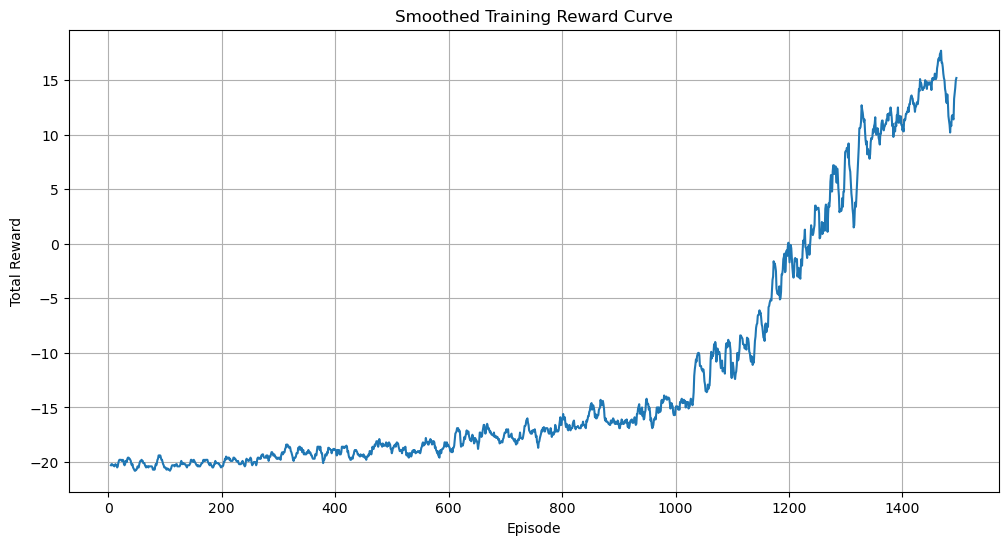

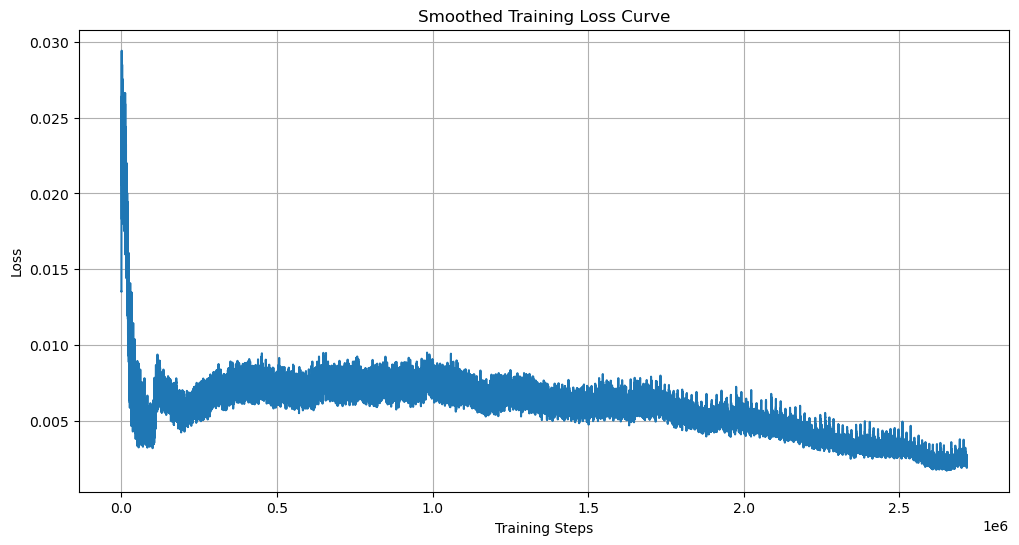

In [18]:
import numpy as np
import matplotlib.pyplot as plt

def smooth(data, window_size=10):
    """
    Smooths the data using a moving average.

    Args:
        data (list or array): The data to smooth.
        window_size (int): The size of the moving window.

    Returns:
        array: The smoothed data.
    """
    data = np.array(data)
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')


# Set the window size for smoothing
reward_window_size = 10 
loss_window_size = 100   

smoothed_rewards = smooth(rewards, window_size=reward_window_size)
reward_episodes = np.arange(len(smoothed_rewards)) + reward_window_size // 2

plt.figure(figsize=(12, 6))
plt.plot(reward_episodes, smoothed_rewards)
plt.title("Smoothed Training Reward Curve")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.show()

# Smooth the losses
smoothed_losses = smooth(losses, window_size=loss_window_size)
loss_steps = np.arange(len(smoothed_losses)) + loss_window_size // 2

plt.figure(figsize=(12, 6))
plt.plot(loss_steps, smoothed_losses)
plt.title("Smoothed Training Loss Curve")
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.grid(True)
plt.show()
